In [26]:
import os
import tweepy
import json
import pandas as pd
import plotly.express as px
import svgutils.compose as sc
import pylustrator
import re
import nltk
import string
import random
from retrying import retry
from geopy.geocoders import Nominatim
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.classify import NaiveBayesClassifier
from collections import Counter
%matplotlib inline

# What is overall attitude of Twitter users towards solar? 

Social networks can provide information about people's attitude regarding a particular topic. For this project I took Twitter data for the USA states with the supposedly greatest exposure to solar, i.e. states with the largest installed solar electricity capacity.

First of all, let's create Twitter API instance.

In [8]:
path = r'd:/edx/sandiego/course1/Week-8-NLP-Databases/twitter'
secrets_file = 'secret_twitter_credentials.json'

In [22]:
with open(os.path.join(path, secrets_file), 'r') as f:
    secrets = json.load(f)

In [23]:
auth = tweepy.OAuthHandler(secrets['API_key'], secrets['API_secret_key'])
auth.set_access_token(secrets['Access_token'], secrets['Access_token_secret'])

api = tweepy.API(auth)

## Best States For Solar Power by Installed Solar Capacity

According to Google search results, the largest volume of installed solar panels belongs to these states:
* California - 21,074 MW.
* North Carolina - 4,308 MW.
* Arizona - 3,400 MW.
* Nevada - 2,595 MW.
* New Jersey - 2,390 MW.
* Massachusetts - 2,011 MW.
* Texas - 1,874 MW.
* Utah - 1,599 MW.

In order to identify these states for Twitter API request we need location latitude, longitude and distance around them.

In [2]:
geolocator = Nominatim(user_agent="ksu_python4ds")
states = ['CA', 'NC', 'AZ', 'NV', 'NJ', 'MA', 'TX', 'UT']
locations = {}
for state in states:
    location = geolocator.geocode(state + ', USA')
    locations[state] = str(location.latitude) + ',' + str(location.longitude) + ',300mi'
print(locations)

{'CA': '36.7014631,-118.755997,300mi', 'NC': '35.6729639,-79.0392919,300mi', 'AZ': '34.395342,-111.763275,300mi', 'NV': '39.5158825,-116.8537227,300mi', 'NJ': '40.0757384,-74.4041622,300mi', 'MA': '42.3788774,-72.032366,300mi', 'TX': '31.8160381,-99.5120986,300mi', 'UT': '39.4225192,-111.714358,300mi'}


Let's also display these states on a map:

In [48]:
fig = px.choropleth(
    locations=states,
    locationmode="USA-states", 
    scope="usa")
fig.update_layout(title_text = 'States with largest installed solar capacity')
fname = os.path.join(path, 'state_map.png')
#plt.savefig(fname, dpi=300)
fig.show()

<Figure size 432x288 with 0 Axes>

## Twitter data

### Collecting data

Let's collect Twitter data for each of the states we identified previously: California, North Carolina, Arizona, Nevada, New Jersey, Massachusetts, Texas, Utah

In [24]:
query = 'solar'
number = 400

ca_search_results = tweepy.Cursor(api.search, q=query, lang='en', geocode = locations['CA']).items(number) 
nc_search_results = tweepy.Cursor(api.search, q=query, lang='en', geocode = locations['NC']).items(number) 
az_search_results = tweepy.Cursor(api.search, q=query, lang='en', geocode = locations['AZ']).items(number) 
nv_search_results = tweepy.Cursor(api.search, q=query, lang='en', geocode = locations['NV']).items(number) 
nj_search_results = tweepy.Cursor(api.search, q=query, lang='en', geocode = locations['NJ']).items(number) 
ma_search_results = tweepy.Cursor(api.search, q=query, lang='en', geocode = locations['MA']).items(number) 
tx_search_results = tweepy.Cursor(api.search, q=query, lang='en', geocode = locations['TX']).items(number) 
ut_search_results = tweepy.Cursor(api.search, q=query, lang='en', geocode = locations['UT']).items(number) 


In [25]:
@retry(wait_exponential_multiplier=1000, wait_exponential_max=10000)
def tweet_list(search_iterator, tweet_list, n_retweeted):
    '''Function calls Twitter API and returns tweets and retweet count for each tweet
    input:  tweepy.Cursor iterator
    output: list of tweets, list of retweet count'''
    try:
        for x in search_iterator:
            tweet_list.append(x.text)
            n_retweeted.append(x.retweet_count)
    except tweepy.error.TweepError:
        raise
    print(len(tweet_list)) 

In [26]:
ca_tweets, ca_retweeted = [], []
nc_tweets, nc_retweeted = [], []
az_tweets, az_retweeted = [], []
nv_tweets, nv_retweeted = [], []
nj_tweets, nj_retweeted = [], []
ma_tweets, ma_retweeted = [], []
tx_tweets, tx_retweeted = [], []
ut_tweets, ut_retweeted = [], []

Let's retrieve tweets about topic "solar" for different states:

In [27]:
tweet_list(ca_search_results, ca_tweets, ca_retweeted)
tweet_list(nc_search_results, nc_tweets, nc_retweeted)
tweet_list(az_search_results, az_tweets, az_retweeted)
tweet_list(nv_search_results, nv_tweets, nv_retweeted)
tweet_list(nj_search_results, nj_tweets, nj_retweeted)
tweet_list(ma_search_results, ma_tweets, ma_retweeted)
tweet_list(tx_search_results, tx_tweets, tx_retweeted)
tweet_list(ut_search_results, ut_tweets, ut_retweeted)

400
400
400
400
400
400
400
400


There are duplicates in Twitter data, we will need to remove them.

In [29]:
filtered_tweets_ca, filtered_retweets_ca = [], []
filtered_tweets_nc, filtered_retweets_nc = [], []
filtered_tweets_az, filtered_retweets_az = [], []
filtered_tweets_nv, filtered_retweets_nv = [], []
filtered_tweets_nj, filtered_retweets_nj = [], []
filtered_tweets_ma, filtered_retweets_ma = [], []
filtered_tweets_tx, filtered_retweets_tx = [], []
filtered_tweets_ut, filtered_retweets_ut = [], []

def filtered_tweets(initial_tweet_list, initial_retweet_list, filtered_tweet_list, filtered_retweet_list):
    for i in initial_tweet_list:
        # if we don't have this tweet stored yet
        if not i in filtered_tweet_list:
            # then add it to the new list
            filtered_tweet_list.append(i)
            # get its index
            y = initial_tweet_list.index(i)
            # and pass index to get the respective number of retweets
            ii = initial_retweet_list[y]
            filtered_retweet_list.append(ii)

    print('tweets: ', len(filtered_tweet_list), '; retweets: ', len(filtered_retweet_list))

Once we remove duplicate tweets there is less tweets left for each of selected states:

In [30]:
filtered_tweets(ca_tweets, ca_retweeted, filtered_tweets_ca, filtered_retweets_ca)
filtered_tweets(nc_tweets, nc_retweeted, filtered_tweets_nc, filtered_retweets_nc)
filtered_tweets(az_tweets, az_retweeted, filtered_tweets_az, filtered_retweets_az)
filtered_tweets(nv_tweets, nv_retweeted, filtered_tweets_nv, filtered_retweets_nv)
filtered_tweets(nj_tweets, nj_retweeted, filtered_tweets_nj, filtered_retweets_nj)
filtered_tweets(ma_tweets, ma_retweeted, filtered_tweets_ma, filtered_retweets_ma)
filtered_tweets(tx_tweets, tx_retweeted, filtered_tweets_tx, filtered_retweets_tx)
filtered_tweets(ut_tweets, ut_retweeted, filtered_tweets_ut, filtered_retweets_ut)

tweets:  236 ; retweets:  236
tweets:  292 ; retweets:  292
tweets:  234 ; retweets:  234
tweets:  210 ; retweets:  210
tweets:  298 ; retweets:  298
tweets:  276 ; retweets:  276
tweets:  297 ; retweets:  297
tweets:  366 ; retweets:  366


### Cleaning up Twitter data

To simplify next steps, let's create dataframes 

In [95]:
ca_df = pd.DataFrame({'Tweet': filtered_tweets_ca, 'Retweet Count': filtered_retweets_ca})
nc_df = pd.DataFrame({'Tweet': filtered_tweets_nc, 'Retweet Count': filtered_retweets_nc})
az_df = pd.DataFrame({'Tweet': filtered_tweets_az, 'Retweet Count': filtered_retweets_az})
nv_df = pd.DataFrame({'Tweet': filtered_tweets_nv, 'Retweet Count': filtered_retweets_nv})
nj_df = pd.DataFrame({'Tweet': filtered_tweets_nj, 'Retweet Count': filtered_retweets_nj})
ma_df = pd.DataFrame({'Tweet': filtered_tweets_ma, 'Retweet Count': filtered_retweets_ma})
tx_df = pd.DataFrame({'Tweet': filtered_tweets_tx, 'Retweet Count': filtered_retweets_tx})
ut_df = pd.DataFrame({'Tweet': filtered_tweets_ut, 'Retweet Count': filtered_retweets_ut})

ut_df.head(20)

,Tweet,Retweet Count
0,China’s Longi Green Energy Technology to Join ...,0
1,DW4988\n🕒 18h | Current weather\n\nWind: 19.0 ...,0
2,DW4988\n🕒 17h | Current weather\n\nWind: 6.0 m...,0
3,love my @Tesla solar system and #Powerwalls. M...,0
4,NUDES plans an undulating 'solar mountain' for...,0
5,"@mjro1105 Solar, wind and other sustainable so...",0
6,@SupraMiqote tax rebate from getting solar ins...,0
7,DW4988\n🕒 16h | Current weather\n\nWind: 8.9 m...,0
8,RT @CityOfLasVegas: A solar house built by @un...,6
9,@MOS_8502 A colleague of mine just set up his ...,0


Now we have 8 dataframes, each of them contains 250 - 350 rows, and columns with tweet and number of retweets.
Tweets contain any text related to solar topic.

As we can see, tweets contain URL's, mentions, RT text. For sentiment analysis we need clean tweets up.

We will use python module re to remove mentions with start with @ and URLs which we can identify for the first http:// or https://
So we remove @ and all concequent characters till the next space.
Similarly, we remove http:// or https:// and all consequent characters till the next space.
We also remove 'RT ' indicating retweet.

In [96]:
def clean_up_tweets(txt):
    # Remove mentions
    txt = re.sub('\S*@\S*\s?', '', txt)
    # Remove urls
    txt = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', txt)
    # Remove retweets:
    txt = re.sub(r'RT ', '', txt)
#     # Remove special chars
#     txt = re.sub(r'&amp;', '', txt)
    return txt  


In [97]:
ca_df['Tweet'] = ca_df['Tweet'].apply(clean_up_tweets)
nc_df['Tweet'] = nc_df['Tweet'].apply(clean_up_tweets)
az_df['Tweet'] = az_df['Tweet'].apply(clean_up_tweets)
nv_df['Tweet'] = nv_df['Tweet'].apply(clean_up_tweets)
nj_df['Tweet'] = nj_df['Tweet'].apply(clean_up_tweets)
ma_df['Tweet'] = ma_df['Tweet'].apply(clean_up_tweets)
tx_df['Tweet'] = tx_df['Tweet'].apply(clean_up_tweets)
ut_df['Tweet'] = ut_df['Tweet'].apply(clean_up_tweets)

ca_df.head(30)

,Tweet,Retweet Count
0,Size of raindrops can help identify potentiall...,0
1,New study ties solar variability to the onset ...,0
2,It's just an erector set in the middle of a ar...,0
3,15 days since Tesla recognized they also have ...,1
4,#PPOD: This image is extraordinary. It shows a...,88
5,Tesla Giga Nevada Adds More Solar Panels in Co...,9
6,Stream Wheein's concept film video moos ❤️ \n\...,2
7,#Minnesota’s community #solar program leads th...,3
8,The “Magical” of using Tesla Solar System with...,28
9,China's green hydrogen gigafactories are comin...,5


Now as we completed cleaning steps, let's take a look at some of tweets:

In [98]:
print(ca_df['Tweet'][:4].tolist())

['Size of raindrops can help identify potentially habitable planets outside our solar system  via ', 'New study ties solar variability to the onset of decadal La Nina events  via ', "It's just an erector set in the middle of a area full of business parks. The first few weeks o… ", '15 days since Tesla recognized they also have a solar division.\n\n660 number of days since Tesla (Solar) admitted they ha…']


We can see that our Twitter data now contains mostly meaningful text.

Also we can notice that after clean up we have columns with no values, we will drop them

In [99]:
ca_df = ca_df.drop(ca_df[ca_df['Tweet'] == ''].index)
nc_df = nc_df.drop(nc_df[nc_df['Tweet'] == ''].index)
az_df = az_df.drop(az_df[az_df['Tweet'] == ''].index)
nv_df = nv_df.drop(nv_df[nv_df['Tweet'] == ''].index)
nj_df = nj_df.drop(nj_df[nj_df['Tweet'] == ''].index)
ma_df = ma_df.drop(ma_df[ma_df['Tweet'] == ''].index)
tx_df = tx_df.drop(tx_df[tx_df['Tweet'] == ''].index)
ut_df = ut_df.drop(ut_df[ut_df['Tweet'] == ''].index)

az_df.head(20)

,Tweet,Retweet Count
0,Joe Biden says that his policies to eliminate ...,30
1,15 days since Tesla recognized they also have ...,1
2,Tesla Giga Nevada Adds More Solar Panels in Co...,9
3,Stream Wheein's concept film video moos ❤️ \n\...,2
4,#Minnesota’s community #solar program leads th...,3
5,The “Magical” of using Tesla Solar System with...,28
6,"HUGE: knocks out some really big ones today, s...",2
7,"I hereby declare today Renewable Blackout Day,...",405
8,"#FunFactFriday: The Pacific Wheel, the world's...",4
9,Buy box in terms of property specific... no so...,0


For the next analisis steps we will use Naive Bayes Classifier from NLTK. It requires a dataset which is already classified.

For the intial classification of tweets we will use TextBlob and its metrics, such as polarity.

## Exploratory Analysis

We can calculate subjectivity and polarity of the tweets with textblob
The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.
We can further classify that: 
* polarity < 0 points to negative tweet
* polarity >= 0 points to positive tweet.
We won't consider subjectivity for now.

In [100]:
def get_text_subjectity(txt):
    return TextBlob(txt).sentiment.subjectivity

def get_text_polarity(txt):
    return TextBlob(txt).sentiment.polarity

Let's apply subjectivity and polarity algorythm to our dataframes:

In [101]:
ca_df['Subjectivity'] = ca_df['Tweet'].apply(get_text_subjectity)
nc_df['Subjectivity'] = nc_df['Tweet'].apply(get_text_subjectity)
az_df['Subjectivity'] = az_df['Tweet'].apply(get_text_subjectity)
nv_df['Subjectivity'] = nv_df['Tweet'].apply(get_text_subjectity)
nj_df['Subjectivity'] = nj_df['Tweet'].apply(get_text_subjectity)
ma_df['Subjectivity'] = ma_df['Tweet'].apply(get_text_subjectity)
tx_df['Subjectivity'] = tx_df['Tweet'].apply(get_text_subjectity)
ut_df['Subjectivity'] = ut_df['Tweet'].apply(get_text_subjectity)

az_df.head(10)

,Tweet,Retweet Count,Subjectivity
0,Joe Biden says that his policies to eliminate ...,30,0.428571
1,15 days since Tesla recognized they also have ...,1,0.000000
2,Tesla Giga Nevada Adds More Solar Panels in Co...,9,0.500000
3,Stream Wheein's concept film video moos ❤️ \n\...,2,0.583333
4,#Minnesota’s community #solar program leads th...,3,0.000000
5,The “Magical” of using Tesla Solar System with...,28,1.000000
6,"HUGE: knocks out some really big ones today, s...",2,0.500000
7,"I hereby declare today Renewable Blackout Day,...",405,0.000000
8,"#FunFactFriday: The Pacific Wheel, the world's...",4,0.333333
9,Buy box in terms of property specific... no so...,0,0.112500


In [102]:
ca_df['Polarity'] = ca_df['Tweet'].apply(get_text_polarity)
nc_df['Polarity'] = nc_df['Tweet'].apply(get_text_polarity)
az_df['Polarity'] = az_df['Tweet'].apply(get_text_polarity)
nv_df['Polarity'] = nv_df['Tweet'].apply(get_text_polarity)
nj_df['Polarity'] = nj_df['Tweet'].apply(get_text_polarity)
ma_df['Polarity'] = ma_df['Tweet'].apply(get_text_polarity)
tx_df['Polarity'] = tx_df['Tweet'].apply(get_text_polarity)
ut_df['Polarity'] = ut_df['Tweet'].apply(get_text_polarity)

tx_df.head(10)

,Tweet,Retweet Count,Subjectivity,Polarity
0,"""This is what a solar eclipse at sunset looks ...",58,0.000000,0.000000
1,HAPPY 25th SOLAR RETURN TO MY SOUL SISTA 🇯🇲💚💫 ...,1,0.833333,0.550000
2,“Climate change is my passion” \n-dude that to...,0,0.437500,0.150000
3,Solar and wind are the only sources of power t...,0,1.000000,0.000000
4,"NW Tarrant Co, Texas\n🕒 19h | Current weather\...",0,0.400000,0.000000
5,Sachse(Woodbridge)\n🕒 19h | Current weather\n\...,0,0.400000,0.000000
6,"Huge news!! just signed Roxy's Law, Community ...",4,0.500000,0.488281
7,"Community Solar, Trapping, Gila:)",1,1.000000,0.500000
8,"""The geochemistry that we examine in this stud...",1,0.000000,0.000000
9,"Community Solar, Trapping, Gila:)",1,1.000000,0.500000


Based on TextBlob polarity definition, we can define classification consisting of three classes: negative (polarity < 0), positive (polarity > 0) and neutral (polarity = 0).
But for Naive Bayes Classifier model we need two classes: negative and positive. Therefore, negative tweets are ones with polartiy < 0. Positive tweets are tweets with polarity >= 0.

Let's create a function and apply to all our dataframes:

In [103]:
def get_classification(tweet_polarity):
    if tweet_polarity < 0:
        c = 'neg'
    else:
        c = 'pos'
    return c    

In [104]:
ca_df['Classification'] = ca_df['Polarity'].apply(get_classification)
nc_df['Classification'] = nc_df['Polarity'].apply(get_classification)
az_df['Classification'] = az_df['Polarity'].apply(get_classification)
nv_df['Classification'] = nv_df['Polarity'].apply(get_classification)
nj_df['Classification'] = nj_df['Polarity'].apply(get_classification)
ma_df['Classification'] = ma_df['Polarity'].apply(get_classification)
tx_df['Classification'] = tx_df['Polarity'].apply(get_classification)
ut_df['Classification'] = ut_df['Polarity'].apply(get_classification)

ma_df.head(10)

,Tweet,Retweet Count,Subjectivity,Polarity,Classification
0,[#마마무] Daily tweet for #MAMAMOO Brand Reputati...,1,0.000000,0.000000,pos
1,The Solar Hu Glides\n (The Human Made Editions...,0,0.100000,0.000000,pos
2,"Eat me, DICKHEAD",0,0.000000,0.000000,pos
3,Longtime EV Club of Connecticut member &amp; a...,1,0.000000,0.000000,pos
4,Another day in moomoo Twitter... \n\n[#마마무] Da...,1,0.000000,0.000000,pos
5,i’m tired of this scorpio moon solar return\n\...,0,0.575000,-0.300000,neg
6,[#마마무] Daily tweet for #MAMAMOO Brand Reputati...,1,0.000000,0.000000,pos
7,SOLAR STORM (#4) | Doomsday: 10 Ways the World...,0,0.550000,0.350000,pos
8,"If you have a brass knuckles tattoo, I hope yo...",0,0.466667,-0.194444,neg
9,"regular NF maybe, BUT.......\n\nagainst those ...",0,0.076923,0.000000,pos


We can see different polarity minimum and maximum values in different states. For example, in California, the min polarity value is -0.5, and first percentile is 0 which tells us that the majority (75% based on recent tweets) of California Twitter users have positive attitude about solar topic, and probably about solar electricity topic in particular.

In [105]:
ca_df.describe()

,Retweet Count,Subjectivity,Polarity
count,236.000000,236.000000,236.000000
mean,105.241525,0.350269,0.144393
std,668.303057,0.310094,0.251238
min,0.000000,0.000000,-0.500000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.342803,0.056250
75%,3.000000,0.536250,0.267045
max,6744.000000,1.000000,1.000000


At the same time, in New Jersey minimum polarity value is -1 indicating more negative opinions exists regarding solar topic. Though, the majority of New Jersey Twitter users (75% based on retrieved tweets) are positive about solar.

In [106]:
nj_df.describe()

,Retweet Count,Subjectivity,Polarity
count,297.000000,297.000000,297.000000
mean,199.151515,0.329427,0.112813
std,3121.958213,0.301020,0.250960
min,0.000000,0.000000,-1.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.333333,0.000000
75%,2.000000,0.500000,0.250000
max,53779.000000,1.000000,1.000000


Let's create another dataframe for plotting data and display state polartiy 

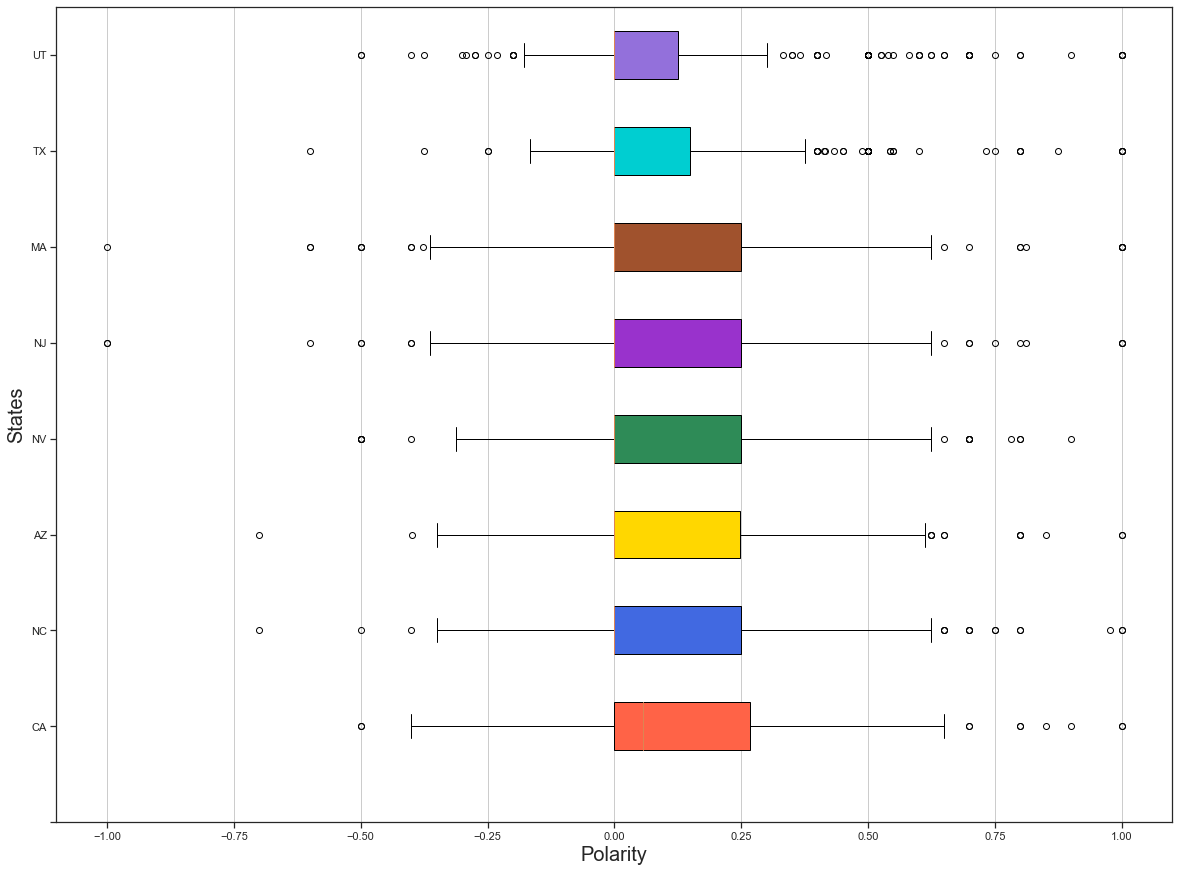

In [107]:
%matplotlib inline

d1 = ca_df['Polarity']
d2 = nc_df['Polarity']
d3 = az_df['Polarity']
d4 = nv_df['Polarity']
d5 = nj_df['Polarity']
d6 = ma_df['Polarity']
d7 = tx_df['Polarity']
d8 = ut_df['Polarity']

data = [d1, d2, d3, d4, d5, d6, d7, d8]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 15))

bplot1 = plt.boxplot(data,
                     vert=False,
                     patch_artist=True)

colors = ['tomato', 'royalblue', 'gold', 'seagreen', 'darkorchid', 'sienna', 'darkturquoise', 'mediumpurple']

for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

axes.xaxis.grid(True)
axes.set_yticks([y for y in range(len(data))], )
axes.set_xlabel('Polarity', fontsize=20)
axes.set_ylabel('States', fontsize=20)

plt.setp(axes, yticks=[y for y in range(len(data) + 1)],
         yticklabels=['', 'CA', 'NC', 'AZ', 'NV', 'NJ', 'MA', 'TX', 'UT'])

plt.show()

As we see on the boxplot graph above, all tweet medium values are neutral, so the 50% of each state tweets mentioning solar are positive.

At the same time, there are strong negative outliers in Massachusets and New Jersey. There are also negative outliers in Arizona and North Carolina tweets. These outliers are worth careful consideration in further researches because they may indicate groups with a negative attitude towards solar energy topic.

Let's create a joined dataframe with an additional column 'State' and take a closer look on the negative tweets.

In [108]:
ca_df['State'] = 'CA'
nc_df['State'] = 'NC'
az_df['State'] = 'AZ'
nv_df['State'] = 'NV'
nj_df['State'] = 'NJ'
ma_df['State'] = 'MA'
tx_df['State'] = 'TX'
ut_df['State'] = 'UT'

ma_df.head(10)

,Tweet,Retweet Count,Subjectivity,Polarity,Classification,State
0,[#마마무] Daily tweet for #MAMAMOO Brand Reputati...,1,0.000000,0.000000,pos,MA
1,The Solar Hu Glides\n (The Human Made Editions...,0,0.100000,0.000000,pos,MA
2,"Eat me, DICKHEAD",0,0.000000,0.000000,pos,MA
3,Longtime EV Club of Connecticut member &amp; a...,1,0.000000,0.000000,pos,MA
4,Another day in moomoo Twitter... \n\n[#마마무] Da...,1,0.000000,0.000000,pos,MA
5,i’m tired of this scorpio moon solar return\n\...,0,0.575000,-0.300000,neg,MA
6,[#마마무] Daily tweet for #MAMAMOO Brand Reputati...,1,0.000000,0.000000,pos,MA
7,SOLAR STORM (#4) | Doomsday: 10 Ways the World...,0,0.550000,0.350000,pos,MA
8,"If you have a brass knuckles tattoo, I hope yo...",0,0.466667,-0.194444,neg,MA
9,"regular NF maybe, BUT.......\n\nagainst those ...",0,0.076923,0.000000,pos,MA


In [109]:
all_df = pd.concat([ca_df, nc_df, az_df, nv_df, nj_df, ma_df, tx_df, ut_df])

all_df.head(-20)

,Tweet,Retweet Count,Subjectivity,Polarity,Classification,State
0,Size of raindrops can help identify potentiall...,0,0.525000,0.000000,pos,CA
1,New study ties solar variability to the onset ...,0,0.454545,0.136364,pos,CA
2,It's just an erector set in the middle of a ar...,0,0.245833,0.100000,pos,CA
3,15 days since Tesla recognized they also have ...,1,0.000000,0.000000,pos,CA
4,#PPOD: This image is extraordinary. It shows a...,88,1.000000,0.333333,pos,CA
5,Tesla Giga Nevada Adds More Solar Panels in Co...,9,0.500000,0.500000,pos,CA
6,Stream Wheein's concept film video moos ❤️ \n\...,2,0.583333,0.408333,pos,CA
7,#Minnesota’s community #solar program leads th...,3,0.000000,0.000000,pos,CA
8,The “Magical” of using Tesla Solar System with...,28,1.000000,0.250000,pos,CA
9,China's green hydrogen gigafactories are comin...,5,0.300000,-0.200000,neg,CA


Now we have 2184 rows with all tweets we collected. Let's calculate how many negative and positive tweets we have across all eight states.

In [110]:
positive = all_df[all_df['Classification'] == 'pos']
positive_share = round(positive.shape[0]/(all_df.shape[0])*100, 2)

print(f'There are {positive_share} of positive tweets across states with the largest installed solar capacity')

There are 89.61 of positive tweets across states with the largest installed solar capacity


89.6% of positive tweets shows that Twitter audience favor solar topic a lot. Let's visualize positive and negative tweets on a plot

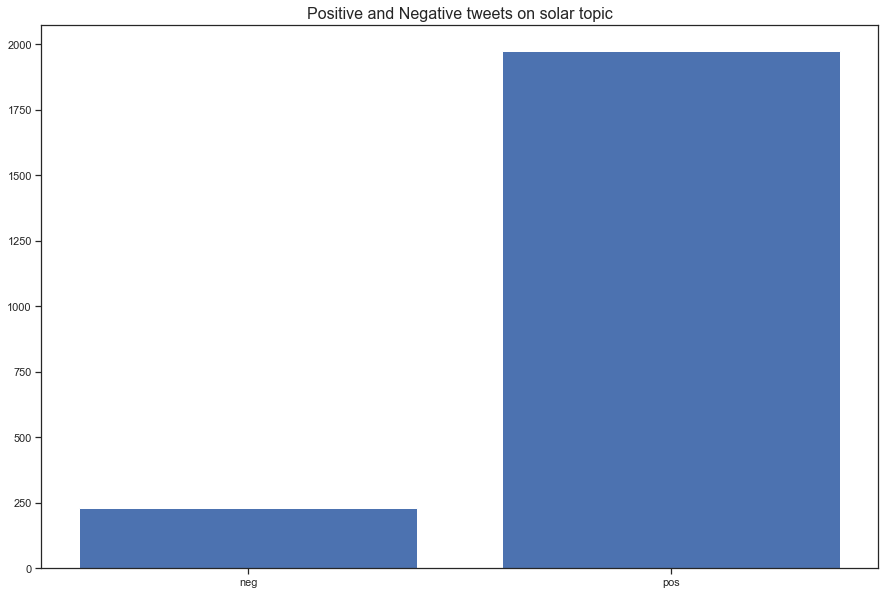

In [126]:
labels = all_df.groupby('Classification').count().index.values
values = all_df.groupby('Classification').size().values
plt.rcParams['figure.figsize'] = (15, 10)

plt.bar(labels, values)
plt.title('Positive and Negative tweets on solar topic', fontsize=16)

plt.show()

Let's also display negatively and positively classified tweets on a scatter plot and see how they are distributes based on polartity and subjectivity metrics:

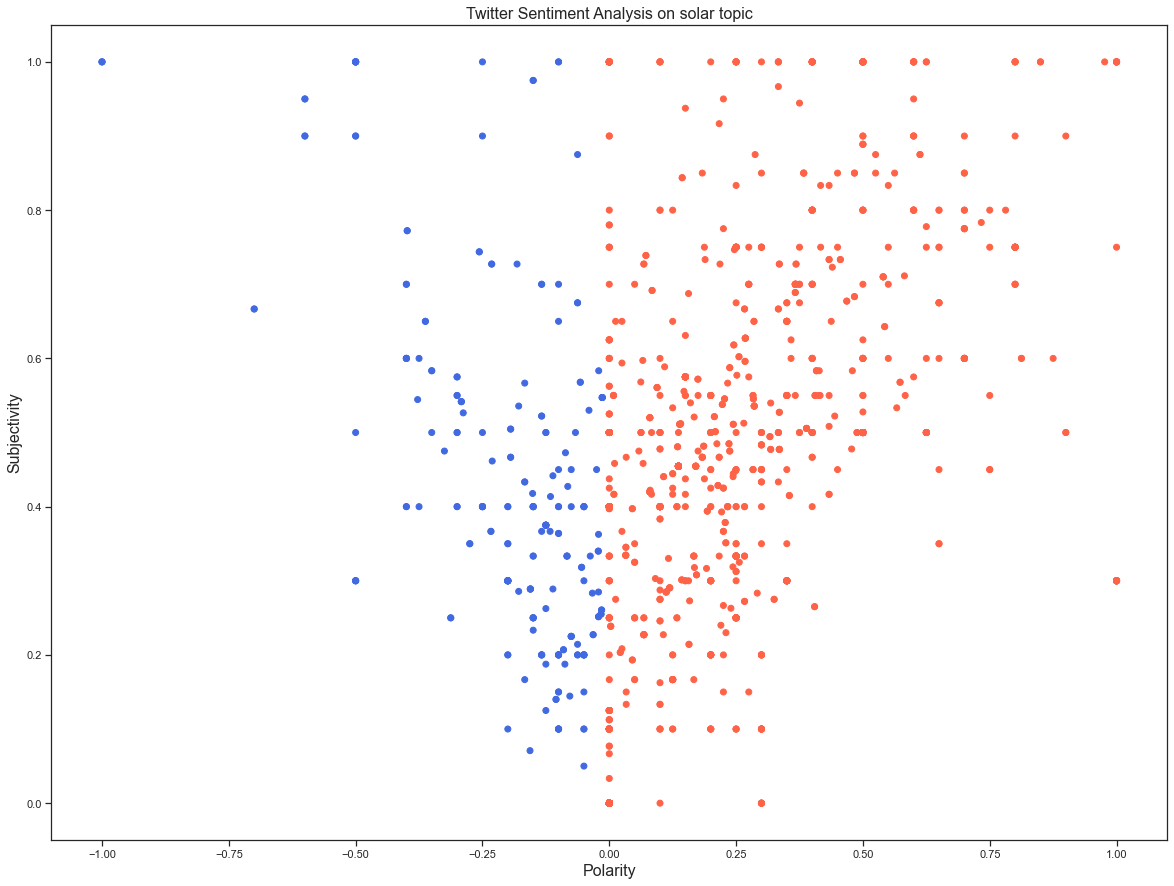

In [139]:
fig, ax = plt.subplots(figsize=(20, 15))

colors = ['tomato', 'royalblue']
color_labels = ['pos', 'neg']
color_map = dict(zip(color_labels, colors))

plt.scatter(all_df['Polarity'], all_df['Subjectivity'], c=all_df['Classification'].map(color_map))

plt.title('Twitter Sentiment Analysis on solar topic', fontsize=16)
plt.xlabel('Polarity', fontsize=16)
plt.ylabel('Subjectivity', fontsize=16)
plt.show()

On the scatterplot above we can see that polarity increases with subjectivity. In other words, among the tweets estimated as most sujective we can see the largest polarity values.

Tweets with low subjectivity values tend to be more positive, so we can can conclude that Twitter users in states with largest installed solar capacity tend to be positive about solar. Though among probably subjective tweets we can meed all specter of opinions.

For the final part of Twitter sentiment analysis let's download NLTK Twitter samples and use NLTK Naive Bayes Classifier model on our categorized tweets.

## Sentiment Analysis using Naive Bayes Classifier

In [140]:
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\surov\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

In [141]:
from nltk.corpus import twitter_samples

Essentially, NLTK corpora has three JSON files with Twitter samples:
* positively and negatively classified tweets;
* tweet samples

In [142]:
twitter_samples.fileids()

['negative_tweets.json', 'positive_tweets.json', 'tweets.20150430-223406.json']

In [143]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

print (len(positive_tweets), '; ', len(negative_tweets))

5000 ;  5000


NLTK Corpora provides 10,000 sample tweets, 5,000 positive tweets and 5,000 negative tweets. Let's take a look at some of them.

In [144]:
positive_tweets[:10]

['#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)',
 '@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!',
 '@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!',
 '@97sides CONGRATS :)',
 'yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days',
 '@BhaktisBanter @PallaviRuhail This one is irresistible :)\n#FlipkartFashionFriday http://t.co/EbZ0L2VENM',
 "We don't like to keep our lovely customers waiting for long! We hope you enjoy! Happy Friday! - LWWF :) https://t.co/smyYriipxI",
 '@Impatientraider On second thought, there’s just not enough time for a DD :) But new shorts entering system. Sheep must be buying.',
 'Jgh , but we have to go to Bayan :D bye',
 'As an act of mischievousness, am calling the ETL layer of our in-house warehousing 

We can see that sample tweets have mentions and URL we have cleaned up from our data. Let's repeat cleaning for NLTK tweet samples as well.

In [145]:
positive_tweets_filtered = []
negative_tweets_filtered = []

for x in positive_tweets:
    positive_tweets_filtered.append(clean_up_tweets(x))

for x in negative_tweets:
    negative_tweets_filtered.append(clean_up_tweets(x))
    
positive_tweets_filtered[:10]

['#FollowFriday for being top engaged members in my community this week :)',
 'Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!',
 'we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!',
 'CONGRATS :)',
 'yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days',
 'This one is irresistible :)\n#FlipkartFashionFriday ',
 "We don't like to keep our lovely customers waiting for long! We hope you enjoy! Happy Friday! - LWWF :) ",
 'On second thought, there’s just not enough time for a DD :) But new shorts entering system. Sheep must be buying.',
 'Jgh , but we have to go to Bayan :D bye',
 'As an act of mischievousness, am calling the ETL layer of our in-house warehousing app Katamari.\n\nWell… as the name implies :p.']

In order to implement classification we need tokenize our datasets and also remove punctuation. We will use NLTK corpora to download stopwords and punctuation characters.

In [146]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\surov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\surov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [147]:
useless_words = nltk.corpus.stopwords.words('english') + list(string.punctuation)

Now let's create functions for creating feature dictionary for our classification model.

In [148]:
def bag_word_features_filter(words):
    return{
        word:1 for word in words \
        if not word in useless_words
    }

def get_filtered_words_list(words):
    return [word.lower() for word in words if not word in useless_words]

print(useless_words[:100])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once']


Now we can tokenize our tweets.

In [149]:
all_df['Words'] = all_df['Tweet'].apply(nltk.word_tokenize)

In [150]:
all_df.head(-20)

,Tweet,Retweet Count,Subjectivity,Polarity,Classification,State,Words
0,Size of raindrops can help identify potentiall...,0,0.525000,0.000000,pos,CA,"[Size, of, raindrops, can, help, identify, pot..."
1,New study ties solar variability to the onset ...,0,0.454545,0.136364,pos,CA,"[New, study, ties, solar, variability, to, the..."
2,It's just an erector set in the middle of a ar...,0,0.245833,0.100000,pos,CA,"[It, 's, just, an, erector, set, in, the, midd..."
3,15 days since Tesla recognized they also have ...,1,0.000000,0.000000,pos,CA,"[15, days, since, Tesla, recognized, they, als..."
4,#PPOD: This image is extraordinary. It shows a...,88,1.000000,0.333333,pos,CA,"[#, PPOD, :, This, image, is, extraordinary, ...."
5,Tesla Giga Nevada Adds More Solar Panels in Co...,9,0.500000,0.500000,pos,CA,"[Tesla, Giga, Nevada, Adds, More, Solar, Panel..."
6,Stream Wheein's concept film video moos ❤️ \n\...,2,0.583333,0.408333,pos,CA,"[Stream, Wheein, 's, concept, film, video, moo..."
7,#Minnesota’s community #solar program leads th...,3,0.000000,0.000000,pos,CA,"[#, Minnesota, ’, s, community, #, solar, prog..."
8,The “Magical” of using Tesla Solar System with...,28,1.000000,0.250000,pos,CA,"[The, “, Magical, ”, of, using, Tesla, Solar, ..."
9,China's green hydrogen gigafactories are comin...,5,0.300000,-0.200000,neg,CA,"[China, 's, green, hydrogen, gigafactories, ar..."


For calculating most common words we will need a list of our words. Let's create it also.

In [151]:
all_df['Filtered_words'] = all_df['Words'].apply(get_filtered_words_list)
all_df.head(10)

,Tweet,Retweet Count,Subjectivity,Polarity,Classification,State,Words,Filtered_words
0,Size of raindrops can help identify potentiall...,0,0.525000,0.000000,pos,CA,"[Size, of, raindrops, can, help, identify, pot...","[size, raindrops, help, identify, potentially,..."
1,New study ties solar variability to the onset ...,0,0.454545,0.136364,pos,CA,"[New, study, ties, solar, variability, to, the...","[new, study, ties, solar, variability, onset, ..."
2,It's just an erector set in the middle of a ar...,0,0.245833,0.100000,pos,CA,"[It, 's, just, an, erector, set, in, the, midd...","[it, 's, erector, set, middle, area, full, bus..."
3,15 days since Tesla recognized they also have ...,1,0.000000,0.000000,pos,CA,"[15, days, since, Tesla, recognized, they, als...","[15, days, since, tesla, recognized, also, sol..."
4,#PPOD: This image is extraordinary. It shows a...,88,1.000000,0.333333,pos,CA,"[#, PPOD, :, This, image, is, extraordinary, ....","[ppod, this, image, extraordinary, it, shows, ..."
5,Tesla Giga Nevada Adds More Solar Panels in Co...,9,0.500000,0.500000,pos,CA,"[Tesla, Giga, Nevada, Adds, More, Solar, Panel...","[tesla, giga, nevada, adds, more, solar, panel..."
6,Stream Wheein's concept film video moos ❤️ \n\...,2,0.583333,0.408333,pos,CA,"[Stream, Wheein, 's, concept, film, video, moo...","[stream, wheein, 's, concept, film, video, moo..."
7,#Minnesota’s community #solar program leads th...,3,0.000000,0.000000,pos,CA,"[#, Minnesota, ’, s, community, #, solar, prog...","[minnesota, ’, community, solar, program, lead..."
8,The “Magical” of using Tesla Solar System with...,28,1.000000,0.250000,pos,CA,"[The, “, Magical, ”, of, using, Tesla, Solar, ...","[the, “, magical, ”, using, tesla, solar, syst..."
9,China's green hydrogen gigafactories are comin...,5,0.300000,-0.200000,neg,CA,"[China, 's, green, hydrogen, gigafactories, ar...","[china, 's, green, hydrogen, gigafactories, co..."


In [152]:
all_word_list = all_df['Filtered_words'].to_list()
all_word_list = sum(all_word_list, [])
all_word_list[:20]

['size',
 'raindrops',
 'help',
 'identify',
 'potentially',
 'habitable',
 'planets',
 'outside',
 'solar',
 'system',
 'via',
 'new',
 'study',
 'ties',
 'solar',
 'variability',
 'onset',
 'decadal',
 'la',
 'nina']

We can see words like 'solar', 'system' in the list of all words from tweets. Let's calculate frequency of words and display top 20 most frequent words we found in tweets with 'solar' topic

In [153]:
all_word_counter = Counter(all_word_list)
all_common_words = all_word_counter.most_common()[:20]

In [155]:
all_common_words

[('solar', 1211),
 ('mph', 495),
 ('wind', 394),
 ('i', 310),
 ('weather', 267),
 ('temperature', 261),
 ('’', 257),
 ('gust', 257),
 ('humidity', 257),
 ('current', 255),
 ('°f', 253),
 ('🕒', 252),
 ('energy', 204),
 ('pressure', 185),
 ("'s", 175),
 ('the', 171),
 ('new', 165),
 ('amp', 153),
 ('dw4988', 143),
 ('power', 139)]

Solar unsurprizingly took a top place in the list, we also see words like wind, energy, pressure, tempreture, amp, power related to solar energy. Let's display the frequency of the words on a plot.

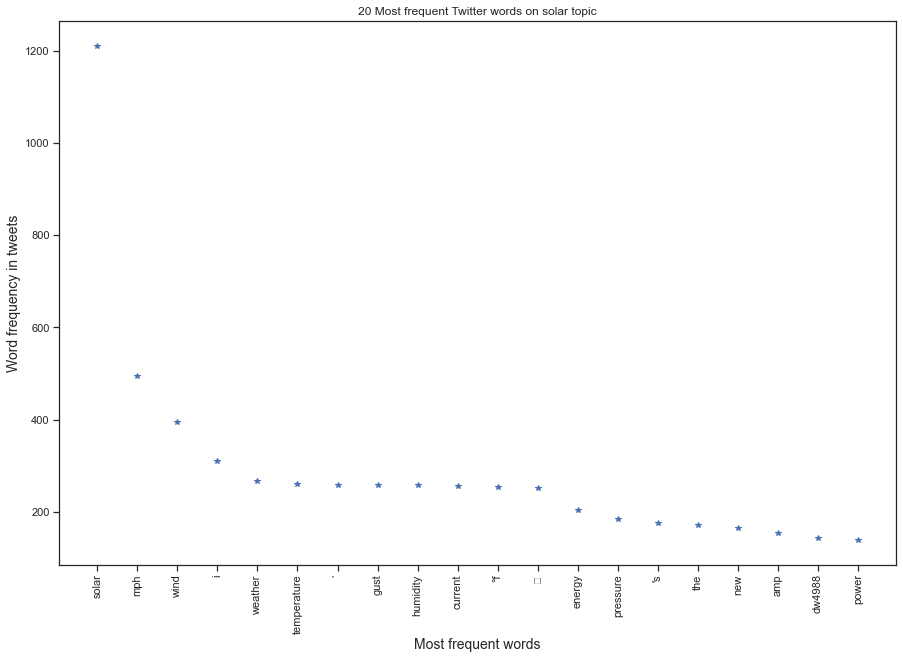

In [162]:
xTicks = []
y = []

for row in all_common_words:
    y.append(int(row[-1]))
    xTicks.append(str(row[-2]))
    
x = range(len(y))
plt.figure(figsize=(15, 10))
plt.xticks(x, xTicks, rotation=90) 
plt.plot(x, y, '*')
plt.xlabel('Most frequent words', fontsize=14)
plt.ylabel('Word frequency in tweets', fontsize=14)
plt.title('20 Most frequent Twitter words on solar topic')

plt.show()

## Training a Classifier for Sentiment Analysis

For Naive Bayes Classifier we need to create a list of positive and negative features. Let's use this classifier on NLTK Twitter sample data first

In [163]:
positive_token_list = []
negative_token_list = []

for i in positive_tweets_filtered:
    positive_token_list.append(nltk.word_tokenize(i.lower()))
positive_token_list = sum(positive_token_list, [])

for i in negative_tweets_filtered:
    negative_token_list.append(nltk.word_tokenize(i.lower()))
negative_token_list = sum(negative_token_list, [])

print(positive_token_list[:100])
print(negative_token_list[:100])

['#', 'followfriday', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':', ')', 'hey', 'james', '!', 'how', 'odd', ':', '/', 'please', 'call', 'our', 'contact', 'centre', 'on', '02392441234', 'and', 'we', 'will', 'be', 'able', 'to', 'assist', 'you', ':', ')', 'many', 'thanks', '!', 'we', 'had', 'a', 'listen', 'last', 'night', ':', ')', 'as', 'you', 'bleed', 'is', 'an', 'amazing', 'track', '.', 'when', 'are', 'you', 'in', 'scotland', '?', '!', 'congrats', ':', ')', 'yeaaaah', 'yippppy', '!', '!', '!', 'my', 'accnt', 'verified', 'rqst', 'has', 'succeed', 'got', 'a', 'blue', 'tick', 'mark', 'on', 'my', 'fb', 'profile', ':', ')', 'in', '15', 'days', 'this', 'one', 'is', 'irresistible', ':', ')', '#', 'flipkartfashionfriday']
['hopeless', 'for', 'tmr', ':', '(', 'everything', 'in', 'the', 'kids', 'section', 'of', 'ikea', 'is', 'so', 'cute', '.', 'shame', 'i', "'m", 'nearly', '19', 'in', '2', 'months', ':', '(', 'that', 'heart', 'sliding', 'into', 'the',

In [164]:
def get_tweets_for_model(token_list):
    for tweet_tokens in token_list:
        return dict([token, True] for token in tweet_tokens)

Once we have a list of words, we can create a feature dictionaries, positive and negative feature dictionary respectively.

In [165]:
positive_features = [
    (bag_word_features_filter(nltk.word_tokenize(f.lower())), 'pos') \
    for f in positive_tweets_filtered
]

In [166]:
print(positive_features[2])

({'listen': 1, 'last': 1, 'night': 1, 'bleed': 1, 'amazing': 1, 'track': 1, 'scotland': 1}, 'pos')


In [167]:
negative_features = [
    (bag_word_features_filter(nltk.word_tokenize(f.lower())), 'neg') \
    for f in negative_tweets_filtered
]

In [168]:
print(negative_features[5])

({'oh': 1, 'god': 1, 'babies': 1, 'faces': 1}, 'neg')


Let's find out the lenght of our feature dictionary:

In [169]:
print(len(negative_features))

5000


We will use 30% split to train our classifier. As we have 10,000 tweet samples, 30% is equal to 3,000 features.

In [170]:
split = 3000

In [171]:
sentiment_classifier = NaiveBayesClassifier.train(positive_features[:split] + negative_features[:split])

Once we trained our model on sample data, we can find out its accuracy on test data:

In [191]:
nltk.classify.util.accuracy(sentiment_classifier, positive_features[split:] + negative_features[split:])

0.5353409090909091

The Naive Bayes classifier shows rather low accuracy on NLTK Twitter sample data. Let's take a look at the list of most informative features:

In [173]:
sentiment_classifier.show_most_informative_features()

Most Informative Features
                     sad = 1                 neg : pos    =     21.3 : 1.0
                      ff = 1                 pos : neg    =     19.7 : 1.0
                    glad = 1                 pos : neg    =     17.7 : 1.0
                    sick = 1                 neg : pos    =     17.7 : 1.0
                   loves = 1                 pos : neg    =     16.2 : 1.0
               community = 1                 pos : neg    =     15.7 : 1.0
                    miss = 1                 neg : pos    =     14.7 : 1.0
                     ugh = 1                 neg : pos    =     13.0 : 1.0
              definitely = 1                 pos : neg    =     12.3 : 1.0
               followers = 1                 pos : neg    =     12.3 : 1.0


As Naive Bayes Classifier is supervising learning model, we need to split our solar-related tweets into two lists: positive and negative tweets. We will do this using classification based on TextBlob polarity metric.

In [174]:
def get_classified_tweet_list(df, cl):
    temp_df = df[df['Classification'] == cl]
    return temp_df['Tweet'].tolist()   

In [175]:
all_pos_tweet_list = get_classified_tweet_list(all_df, 'pos')
all_neg_tweet_list = get_classified_tweet_list(all_df, 'neg')

Let's take a look at some of negative tweets:

In [176]:
all_neg_tweet_list[:10]

["China's green hydrogen gigafactories are coming...",
 'China’s Longi Green Energy Technology to Join Hydrogen Market, Solarzoom Says - Bloomberg ',
 "Voyager 1's Pale Blue Dot | NASA Solar System Exploration -&gt; The Pale Blue Dot is a photograph of Earth taken Feb.… ",
 'There goes #Texas messing with Texas.\n\nBunch of cowardly jackasses.\n\n',
 'TX is having an electricity crisis during bad winter weather because it did not focus enough on building reliable power pl…',
 "I'm not sure why the future tense is being used here, since it has been going on for a whi… ",
 "there's been at least 4 ice ages in the last couple of hundreds of years. The entire solar system is experi… ",
 'A part of me is looking forward to the one year anniversary of ordering solar from late last July thinking i… ',
 'how long of a wait should we expect solar roof orders to be fulfilled?',
 "China's green hydrogen gigafactories are coming..."]

And create another set of dictionaries for positive and negative features out of tweets we collected.

In [177]:
all_positive_features = [
    (bag_word_features_filter(nltk.word_tokenize(f.lower())), 'pos') \
    for f in all_pos_tweet_list
]

In [178]:
all_negative_features = [
    (bag_word_features_filter(nltk.word_tokenize(f.lower())), 'neg') \
    for f in all_neg_tweet_list
]

Also, let's check some features:

In [179]:
print(all_positive_features[:2])
print(all_negative_features[2:4])

[({'size': 1, 'raindrops': 1, 'help': 1, 'identify': 1, 'potentially': 1, 'habitable': 1, 'planets': 1, 'outside': 1, 'solar': 1, 'system': 1, 'via': 1}, 'pos'), ({'new': 1, 'study': 1, 'ties': 1, 'solar': 1, 'variability': 1, 'onset': 1, 'decadal': 1, 'la': 1, 'nina': 1, 'events': 1, 'via': 1}, 'pos')]
[({'voyager': 1, '1': 1, "'s": 1, 'pale': 1, 'blue': 1, 'dot': 1, 'nasa': 1, 'solar': 1, 'system': 1, 'exploration': 1, 'gt': 1, 'photograph': 1, 'earth': 1, 'taken': 1, 'feb.…': 1}, 'neg'), ({'goes': 1, 'texas': 1, 'messing': 1, 'bunch': 1, 'cowardly': 1, 'jackasses': 1}, 'neg')]


We will use similar 30% split for testing and training datasets. First, let's find out the size of our dataset

In [193]:
print(len(all_positive_features) + len(all_negative_features))

2204


In [194]:
split = 650

In [195]:
sentiment_classifier = NaiveBayesClassifier.train(all_positive_features[:split] + all_negative_features[:split])

In [196]:
nltk.classify.util.accuracy(sentiment_classifier, all_positive_features[:split] + all_negative_features[:split])

0.9510807736063709

Model accuracy on train data is 95% which is high.

In [197]:
nltk.classify.util.accuracy(sentiment_classifier, all_positive_features[split:] + all_negative_features[split:])

0.7781132075471698

Model accuracy on test data is 77.8% which is much higher than on Twitter sample data. TextBlob classification works well with NLTK Naive Bayes Classifier on our data. Let's take a look at the most informative features identified by Naive Bayes classifier:

In [198]:
sentiment_classifier.show_most_informative_features()

Most Informative Features
                   every = 1                 neg : pos    =     14.2 : 1.0
                  remote = 1                 neg : pos    =     14.2 : 1.0
                   green = 1                 neg : pos    =     13.1 : 1.0
                 parking = 1                 neg : pos    =     12.3 : 1.0
                   waste = 1                 neg : pos    =     12.3 : 1.0
                  behind = 1                 neg : pos    =     10.4 : 1.0
              electrical = 1                 neg : pos    =     10.4 : 1.0
                 install = 1                 neg : pos    =     10.4 : 1.0
                     per = 1                 neg : pos    =     10.4 : 1.0
                hydrogen = 1                 neg : pos    =      9.3 : 1.0


## Conclusion

Finally, we create a word cloud to get some impression which words used most often in Twitter for topics related to solar.

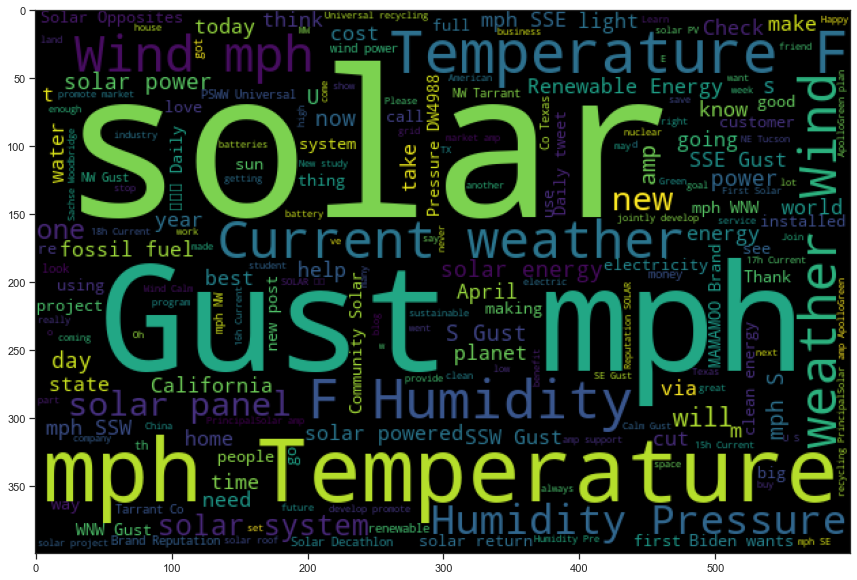

In [199]:
words = ' '.join([tweet for tweet in all_df['Tweet']])
wordCloud = WordCloud(width=600, height=400).generate(words)

plt.imshow(wordCloud)
plt.show()

Based on conducted analysis, we can conclude that majority of Twitter users from Californica, North Carolina, Arizona, Nevada, New Jersey, Massachusetts, Texas, Utah positively speak about solar.

Among these US states with the largest installed solar capacity we did not find any where Twitter users have neutral or negative attitude towards solar topic.

From collected tweets and word cloud we also see that news about solar ofter related to weather conditions, solar panels, renewable energy, including physical units of energy and weather condition. From curious things, we can notice the name of Mr. Biden who recently announced major efforts on increasing the amounts of energy produced in US from solar, including reducing solar cost by 60% in 10 years.